# Wpływ pozycji kwalifikacyjnej na wyniki w wyścigu

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error

In [27]:
qualifying = pd.read_csv('qualifying.csv')
results = pd.read_csv('results.csv')
races = pd.read_csv('races.csv')
drivers = pd.read_csv('drivers.csv')
constructors = pd.read_csv('constructors.csv')

# Połączenie ramek danych i wybór odpowiednich kolumn

### Wybieramy dane po roku 2019, gdyż wtedy wprowadzono ostatnie zmiany dotyczące systemu punktacji wyników

In [28]:
merged_df = pd.merge(qualifying, results[['raceId', 'driverId', 'positionOrder', 'points']], on=['raceId', 'driverId'], how='left')

merged_df = pd.merge(merged_df, constructors[['constructorId', 'name']], on='constructorId', how='left')

merged_df = pd.merge(merged_df, races[['raceId', 'year']], on='raceId', how='left')

merged_df['q3'].replace('\\N', np.nan, inplace=True)
merged_df['q2'].replace('\\N', np.nan, inplace=True)
merged_df['q1'].replace('\\N', np.nan, inplace=True)


def time_to_milliseconds(time_str):
    try:
        if pd.isna(time_str):
            return None
        minutes, seconds_millis = time_str.split(':')
        seconds, milliseconds = seconds_millis.split('.')
        total_milliseconds = (int(minutes) * 60 * 1000) + \
            (int(seconds) * 1000) + int(milliseconds)
        return total_milliseconds
    except ValueError as e:
        print(f"Error converting time: {time_str}, error: {e}")
        return None


merged_df['q1_milliseconds'] = merged_df['q1'].apply(time_to_milliseconds)
merged_df['q2_milliseconds'] = merged_df['q2'].apply(time_to_milliseconds)
merged_df['q3_milliseconds'] = merged_df['q3'].apply(time_to_milliseconds)

merged_df = merged_df[merged_df['year'] >= 2019]

final_df = merged_df[['raceId', 'driverId', 'constructorId', 'q1_milliseconds',
                        'q2_milliseconds', 'q3_milliseconds', 'points', 'positionOrder', 'name']]

final_df['name'].replace(
    {'Sauber': 'Alfa Romeo'}, inplace=True)
final_df['name'].replace(
    {'Toro Rosso': 'AlphaTauri'}, inplace=True)
final_df['name'].replace(
    {'Renault': 'Alpine F1 Team'}, inplace=True)
final_df['name'].replace(
    {'Racing Point': 'Aston Martin'}, inplace=True)
final_df['name'].replace(
    {'Force India': 'Aston Martin'}, inplace=True)


print(final_df.head())

# final_df.to_csv('f1_qualifying_race_performance.csv', index=False)

      raceId  driverId  constructorId  q1_milliseconds  q2_milliseconds  \
7936    1010         1            131          82043.0          81014.0   
7937    1010       822            131          82367.0          81193.0   
7938    1010        20              6          82885.0          81912.0   
7939    1010       830              9          82876.0          81678.0   
7940    1010       844              6          82017.0          81739.0   

      q3_milliseconds  points  positionOrder      name  
7936          80486.0    18.0              2  Mercedes  
7937          80598.0    26.0              1  Mercedes  
7938          81190.0    12.0              4   Ferrari  
7939          81320.0    15.0              3  Red Bull  
7940          81442.0    10.0              5   Ferrari  


C:\Users\domin\AppData\Local\Temp\ipykernel_24180\1464336444.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['q3'].replace('\\N', np.nan, inplace=True)
C:\Users\domin\AppData\Local\Temp\ipykernel_24180\1464336444.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [29]:
final_df.shape

(1877, 9)

In [30]:
final_df.head()

,raceId,driverId,constructorId,q1_milliseconds,q2_milliseconds,q3_milliseconds,points,positionOrder,name
7936,1010,1,131,82043.0,81014.0,80486.0,18.0,2,Mercedes
7937,1010,822,131,82367.0,81193.0,80598.0,26.0,1,Mercedes
7938,1010,20,6,82885.0,81912.0,81190.0,12.0,4,Ferrari
7939,1010,830,9,82876.0,81678.0,81320.0,15.0,3,Red Bull
7940,1010,844,6,82017.0,81739.0,81442.0,10.0,5,Ferrari


In [31]:
print(final_df.dtypes)
final_df = final_df.dropna(
    subset=['q1_milliseconds', 'q2_milliseconds', 'q3_milliseconds'])
final_df.isna().sum()

raceId               int64
driverId             int64
constructorId        int64
q1_milliseconds    float64
q2_milliseconds    float64
q3_milliseconds    float64
points             float64
positionOrder        int64
name                object
dtype: object


raceId             0
driverId           0
constructorId      0
q1_milliseconds    0
q2_milliseconds    0
q3_milliseconds    0
points             0
positionOrder      0
name               0
dtype: int64

In [32]:
final_df.shape

(912, 9)

In [33]:
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
raceId,912.0,1059.250000,29.240796,1010.0,1033.75,1060.0,1084.00,1110.0
driverId,912.0,672.743421,326.966562,1.0,815.00,830.0,844.00,857.0
constructorId,912.0,75.961623,83.489245,1.0,6.00,9.0,131.00,214.0
q1_milliseconds,912.0,85101.562500,13180.918050,53904.0,76521.75,83336.0,92348.00,127614.0
q2_milliseconds,912.0,84269.801535,12551.820702,53647.0,76054.50,83140.0,91481.25,117354.0
q3_milliseconds,912.0,84201.760965,12450.609338,53377.0,75565.25,83503.0,91336.25,123513.0
points,912.0,9.140351,8.120290,0.0,1.00,8.0,15.00,26.0
positionOrder,912.0,7.388158,5.564766,1.0,3.00,6.0,10.00,20.0


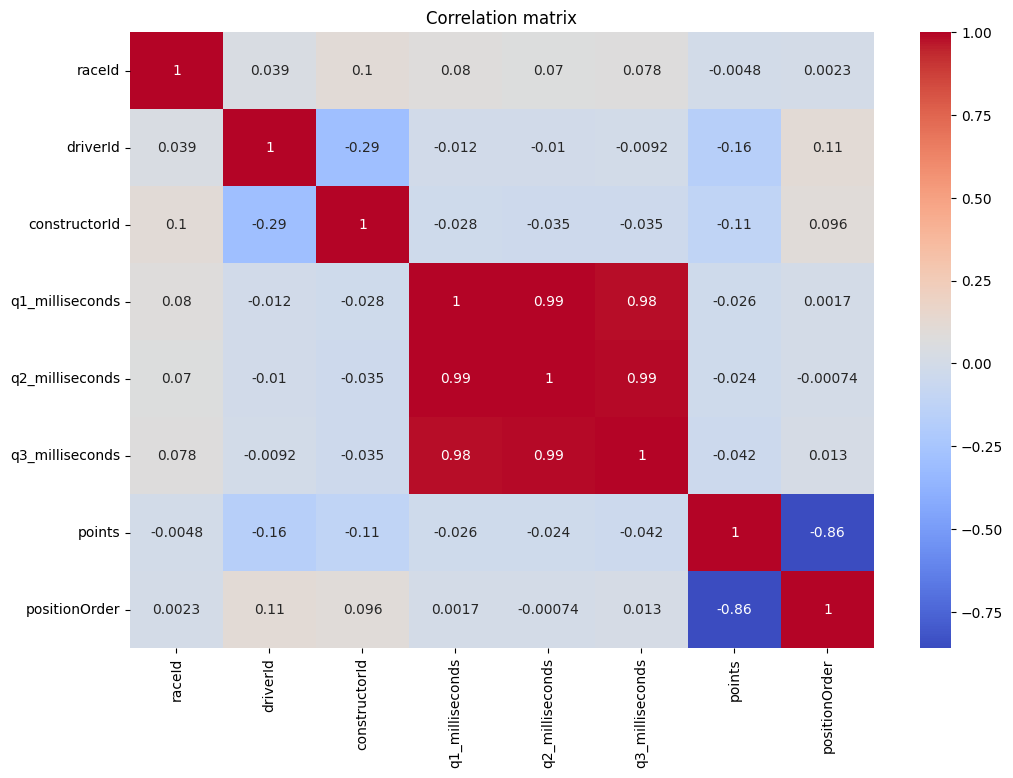

In [34]:
correct_columns = final_df.select_dtypes(include=['float', 'int'])
correlation_matrix = correct_columns.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

### Zmienna objaśniana - points
### Zmienna objaśniająca - positionOrder

# 2.

In [35]:
final_df.describe()['points']

count    912.000000
mean       9.140351
std        8.120290
min        0.000000
25%        1.000000
50%        8.000000
75%       15.000000
max       26.000000
Name: points, dtype: float64

 - Średnie wyniki: średnia wynosząca 7,95 punktu oznacza, że ​​kierowcy zdobywają średnio około 8 punktów w wyścigu.
 - Rozkład i rozrzut: Mediana wartości 6 punktów sugeruje, że rozkład punktów jest nieco wypaczony, ponieważ średnia jest nieco wyższa od mediany. Odchylenie standardowe wynoszące 7,71 punktu wskazuje na znaczne zróżnicowanie punktów zdobytych w poszczególnych wyścigach.
 - Wyścigi, w których nie zdobywa się punktów: Fakt, że 25% wyścigów ma 0 punktów, wskazuje, że niezdobycie żadnych punktów w wyścigu jest dość powszechne.
 - Najlepsze wyniki: Maksymalna liczba zdobytych punktów (26) sugeruje, że w niektórych wyścigach kierowcy zdobywają znacząco wysokie punkty, co może wynikać z systemu punktacji lub wyjątkowych wyników.

### Wykres ramka wąsy dla mediany

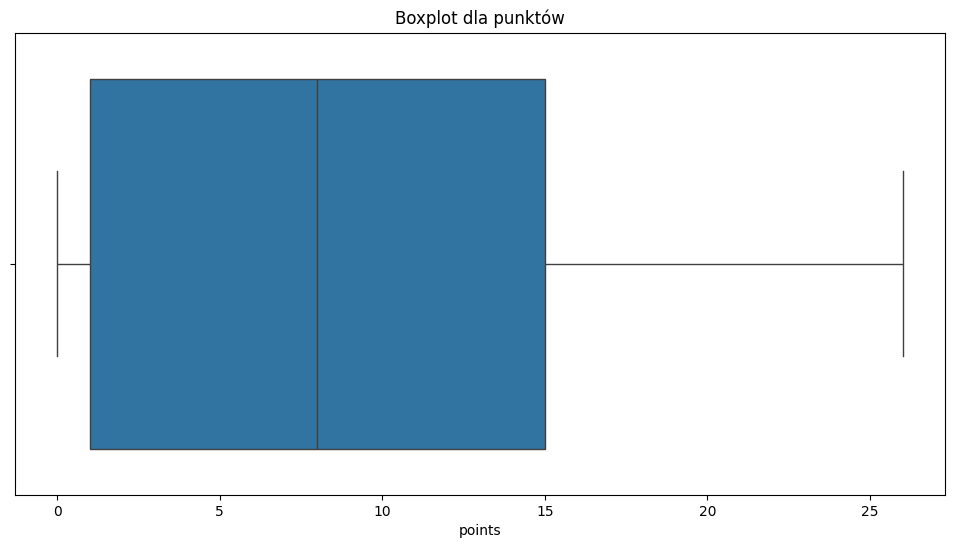

In [36]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=final_df['points'])
plt.title('Boxplot dla punktów')
plt.show()

 - Większość zdobytych punktów jest stosunkowo skondensowana wokół mediany.
 - Rozkład punktów jest nieco asymetryczny z dłuższym wąsem po prawej stronie, co sugeruje, że są pewne wyścigi, w których kierowcy zdobywają znacznie więcej punktów niż przeciętnie.
 - Dolny kwartyl (Q1) pokazuje, że 25% kierowców zdobywa mniej niż około 3 punkty, co może wskazywać na częstą sytuację, gdzie wielu kierowców nie zdobywa punktów lub zdobywa ich bardzo mało.

### Histogram dla punktów

In [37]:
points_26 = final_df[final_df['points'] == 26]
points_26

,raceId,driverId,constructorId,q1_milliseconds,q2_milliseconds,q3_milliseconds,points,positionOrder,name
7937,1010,822,131,82367.0,81193.0,80598.0,26.0,1,Mercedes
8015,1014,1,131,77292.0,76038.0,76040.0,26.0,1,Mercedes
8096,1018,830,9,63807.0,63835.0,63439.0,26.0,1,Red Bull
8115,1019,1,131,85513.0,85840.0,85099.0,26.0,1,Mercedes
8135,1020,830,9,72593.0,72427.0,72113.0,26.0,1,Red Bull
8235,1025,1,131,93230.0,93134.0,92030.0,26.0,1,Mercedes
8334,1030,1,131,95851.0,95634.0,94779.0,26.0,1,Mercedes
8413,1033,1,131,74907.0,74261.0,73447.0,26.0,1,Mercedes
8514,1039,1,131,75778.0,75309.0,75144.0,26.0,1,Mercedes
8536,1040,822,131,92656.0,92405.0,91956.0,26.0,1,Mercedes


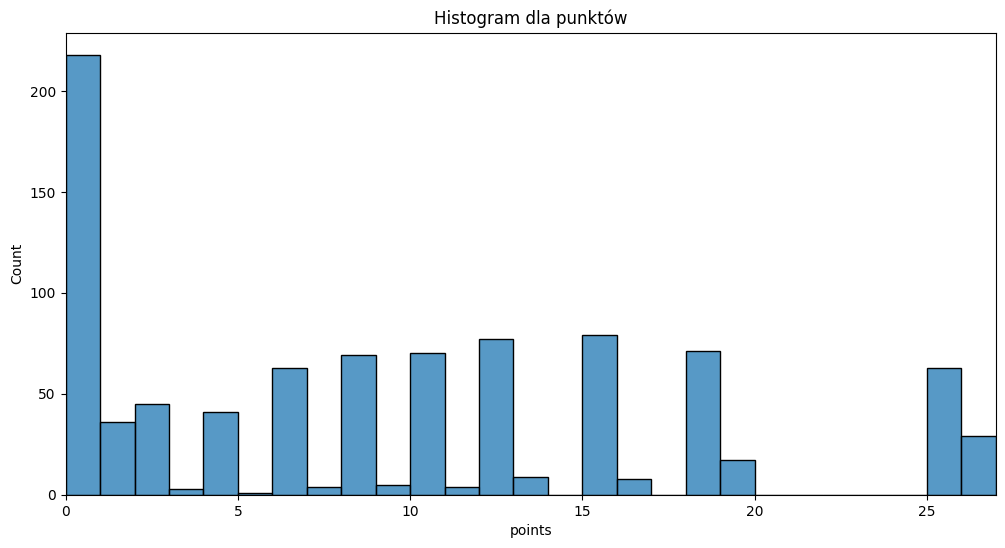

In [38]:
plt.figure(figsize=(12, 6))
sns.histplot(final_df['points'], bins=range(0, 28, 1))
plt.title('Histogram dla punktów')
plt.xlim(0, 27)
plt.show()

 - Duża liczba zerowych punktów może wskazywać na to, że wiele zespołów i kierowców ma trudności z regularnym zdobywaniem punktów w wyścigach.
 - Rozkład punktów jest zróżnicowany, ale większość kierowców zdobywa poniżej 10 punktów na wyścig.
 - Wyraźne piki w punktach 15, 18 i 25 mogą sugerować, że niektórzy kierowcy, gdy już zdobywają punkty, to często są to znaczne ilości punktów.

### Wykres ramka-wąsy skategoryzowany po nazwie drużyny

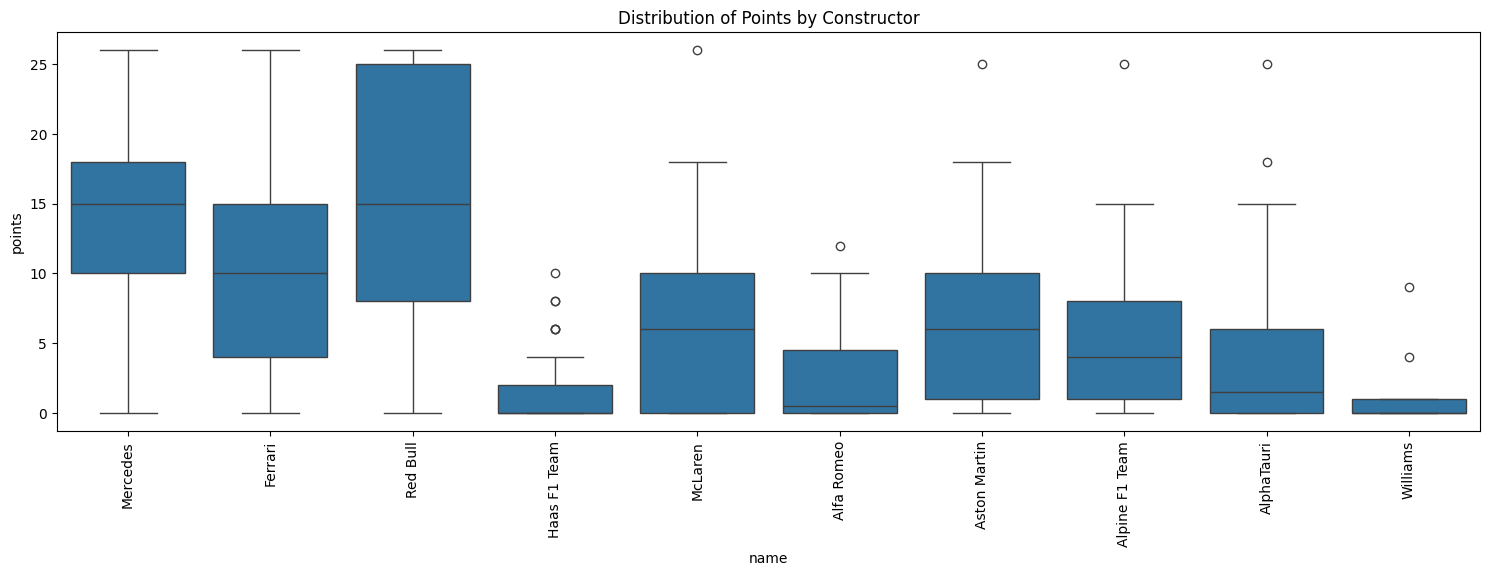

In [39]:
# Set the figure size for better readability
plt.figure(figsize=(15, 10))

# Categorized Box Plot (by Constructor)
plt.subplot(2, 1, 1)
sns.boxplot(x='name', y='points', data=final_df)
plt.title('Distribution of Points by Constructor')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

 - Red Bull, Mercedes i Ferrari to zespoły, które zdobywają najwięcej punktów, co widać po ich medianach.
 - Haas F1 Team i Williams mają najniższe mediany punktów, co wskazuje na problemy z regularnym zdobywaniem punktów.
 - Wiele zespołów ma widoczne punkty odstające, co sugeruje, że zdarza im się zdobywać większą ilość punktów w niektórych wyścigach, mimo że ogólnie zdobywają ich niewiele.

### Histogram skategoryzowany po nazwie drużyny

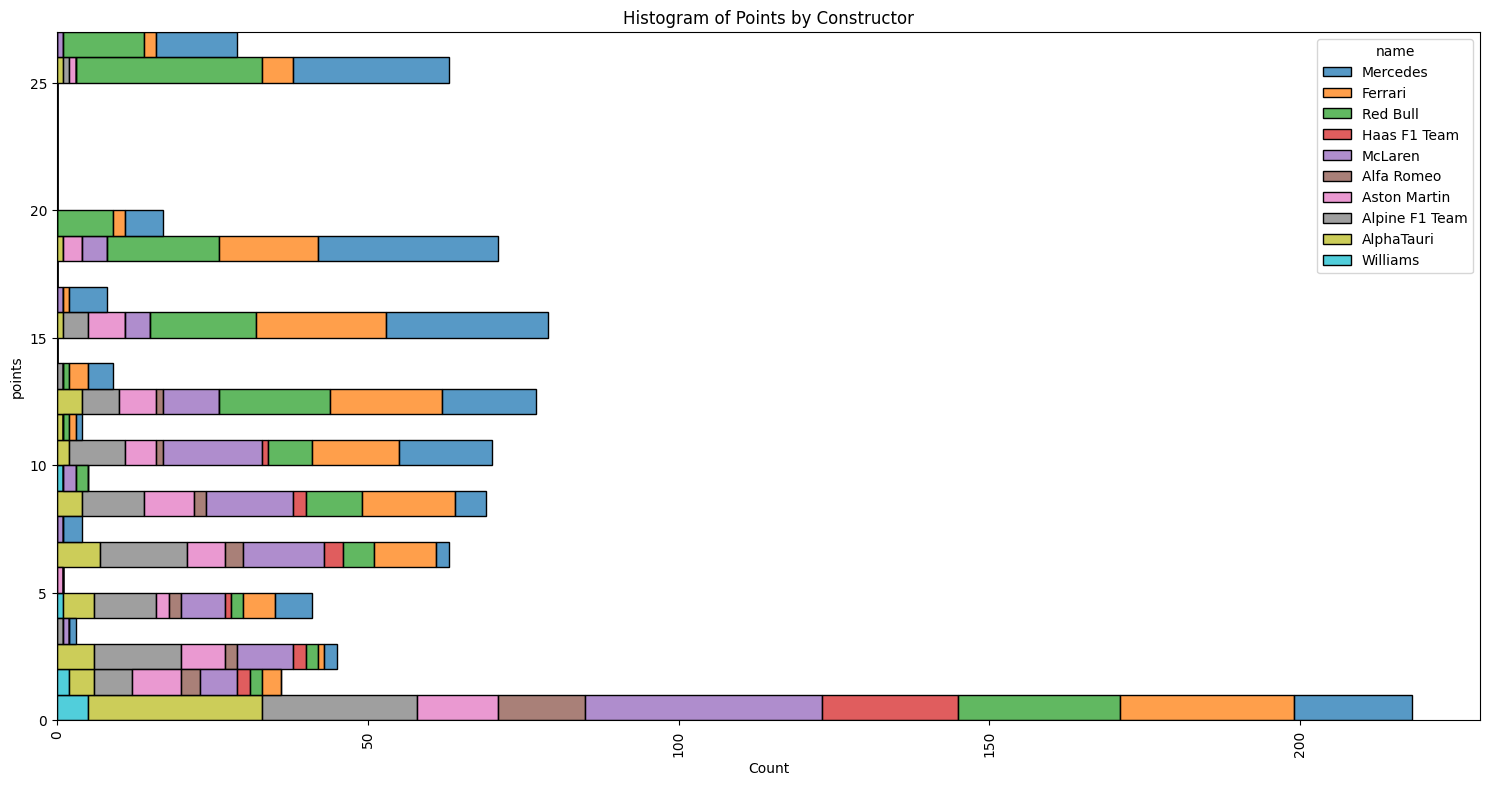

In [40]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 2)

sns.histplot(data=final_df, y='points', hue='name', multiple='stack',
             binwidth=1, binrange=(0, final_df['points'].max() + 1))
plt.title('Histogram of Points by Constructor')
plt.xticks(rotation=90)
plt.ylim(0, 27)

plt.tight_layout()
plt.show()

 - Mercedes i Red Bull są zespołami, które najczęściej zdobywają maksymalne punkty, co wskazuje na ich dominację.
 - Ferrari również zdobywa dużo punktów, ale nie tak regularnie jak Mercedes i Red Bull.
 - McLaren i Alpine F1 Team są zespołami zdobywającymi punkty regularnie, ale w mniejszych ilościach.
 - Haas F1 Team, Alfa Romeo, Aston Martin, AlphaTauri i Williams zdobywają punkty rzadziej i w mniejszych ilościach, co wskazuje na ich niższą wydajność w wyścigach.

# 3.

### Weryfikacja hipotezy o zgodności rozkładu zmiennej zależnej z rozkładem normalnym

In [41]:
train_df, test_df = train_test_split(final_df.select_dtypes(include=['float', 'int']), test_size=0.2, random_state=42)

train_points = train_df['points']

stat, p_value = shapiro(train_points)

print('Shapiro-Wilk Test Statistics:', stat)
print('p-value:', p_value)

alpha = 0.05
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data follows a normal distribution")
else:
    print("Reject the null hypothesis: The data does not follow a normal distribution")

Shapiro-Wilk Test Statistics: 0.895734340729037
p-value: 8.032768445372494e-22
Reject the null hypothesis: The data does not follow a normal distribution


Interpretacja:
1. Statystyka testowa:
 - Statystyka testu Shapiro-Wilka (0,8979760607443914) mierzy, jak dobrze dane pasują do rozkładu normalnego. Wartość bliższa 1 wskazuje, że dane mają większy rozkład normalny. Jednak sama ta wartość nie jest wystarczająca do wyciągania wniosków bez uwzględnienia wartości p.

2. p-value:
 - Wartość p (8,032768445372494e-22) to prawdopodobieństwo otrzymania statystyki testowej co najmniej tak ekstremalnej jak obserwowana, przy założeniu hipotezy zerowej, że dane mają rozkład normalny.
 - W tym przypadku wartość p jest wyjątkowo mała (znacznie mniejsza niż 0,05), co stanowi typowy próg (poziom alfa) używany do testowania hipotez.

Decyzja:
 - Ponieważ wartość p (8,032768445372494e-22) jest znacznie mniejsza niż poziom alfa wynoszący 0,05, odrzucamy hipotezę zerową.

Konkluzja:
 - Odrzuć hipotezę zerową: dane nie mają rozkładu normalnego.
 - Wynik ten wskazuje, że rozkład punktów zdobytych w wyścigach znacznie odbiega od rozkładu normalnego.

### Związek korelacyjny pomiędzy badanymi zmiennymi

In [42]:
final_df[['points', 'positionOrder']].corr()

,points,positionOrder
points,1.000000,-0.858763
positionOrder,-0.858763,1.000000


1. Współczynnik korelacji między points a positionOrder:

 - Wartość: -0,858763
 - Interpretacja:
 - Współczynnik korelacji wynosi -0,858763, co wskazuje na silną ujemną korelację pomiędzy liczbą zdobytych punktów a kolejnością miejsc w wyścigu.
 - Ujemna korelacja oznacza, że ​​wraz ze wzrostem positionOrder (gorsza pozycja końcowa) zdobyte punkty mają tendencję do zmniejszania się.
 - Innymi słowy, kierowcy, którzy zaczynają na lepszych pozycjach (niższe wartości positionOrder), zwykle zdobywają więcej punktów.

2. Współczynnik korelacji pomiędzy positionOrder a points:

 - Wartość: -0,858763
 - Interpretacja:
    - Zasadniczo jest to to samo, co pierwsza interpretacja, ale widziane z perspektywy positionOrder. Przypomina, że ​​wyższa pozycja początkowa (niższa wartość liczbowa dla positionOrder) wiąże się z wyższą liczbą punktów.

### Podsumowanie:
 - Silna ujemna korelacja: Silny ujemny współczynnik korelacji wynoszący -0,858763 sugeruje, że istnieje znacząca odwrotna zależność pomiędzy pozycją na początku wyścigu a zdobytymi punktami. Kierowcy, którzy zaczynają na najwyższych pozycjach, gromadzą zwykle więcej punktów.
 - Praktyczne implikacje: Ta korelacja sugeruje, że często to jak kierowcy poradzą sobie w kwalifikacjach ma duży wpływ na to ile punktów zdobędą w wyścigu

### Model

In [43]:
x = final_df[['positionOrder']]
y = final_df[['points']]

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

for subset in [x, y, X_train, y_train, X_test, y_test]:
    print(subset.shape)

print(f'test percentage: {X_test.shape[0] / x.shape[0] * 100:.2f}%')

(912, 1)
(912, 1)
(729, 1)
(729, 1)
(183, 1)
(183, 1)
test percentage: 20.07%


In [44]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [45]:
model.coef_

array([[-1.26849731]])

In [46]:
model.intercept_

array([18.53581426])

In [47]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

print(f'R2:\n Train: {r2_train}\n Test: {r2_test}')
print(f'MAE:\n Train: {mae_train}\n Test: {mae_test}')
print(f'MSE:\n Train: {mse_train}\n Test: {mse_test}')
print(f'RMSE:\n Train: {rmse_train}\n Test: {rmse_test}')

R2:
 Train: 0.7346447630318073
 Test: 0.7490957546853504
MAE:
 Train: 3.5510140240129453
 Test: 3.1875867706141903
MSE:
 Train: 17.885650547673674
 Test: 14.965158201058742
RMSE:
 Train: 4.229143003928062
 Test: 3.8684826742611556


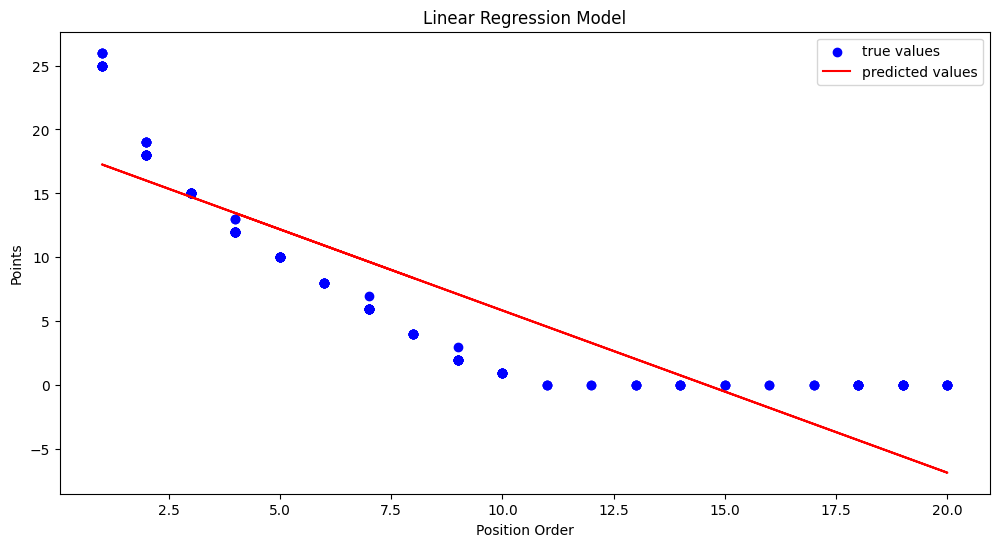

In [50]:
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, color='blue', label='true values')
plt.plot(X_test, model.predict(X_test), color='red', label='predicted values')
plt.title('Linear Regression Model')
plt.xlabel('Position Order')
plt.ylabel('Points')
plt.legend()
plt.show()

 - Model regresji liniowej dobrze odzwierciedla ogólną tendencję spadku punktów wraz z pogarszającą się pozycją startową.
 - Model jest dokładniejszy dla czołowych pozycji startowych, natomiast dla dalszych pozycji jego dokładność spada.


In [51]:
final_df['predicted_points'] = model.predict(x)
final_df['residuals'] = final_df['points'] - final_df['predicted_points']
final_df['residuals'].describe()

count    912.000000
mean      -0.023605
std        4.161498
min       -7.461825
25%       -3.313847
50%       -1.461825
75%        2.001180
max        8.732683
Name: residuals, dtype: float64

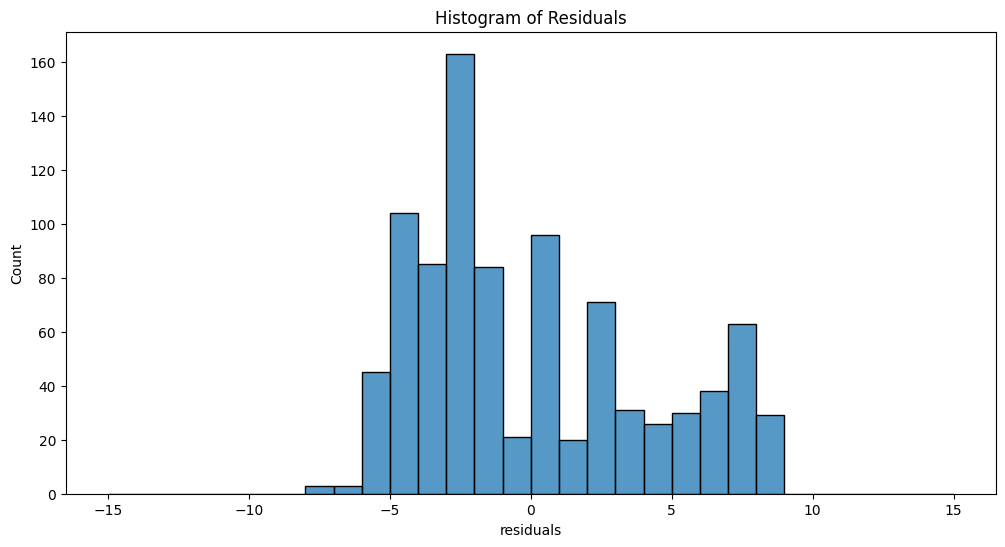

In [52]:
plt.figure(figsize=(12, 6))
sns.histplot(final_df['residuals'], bins=range(-15, 16, 1))
plt.title('Histogram of Residuals')
plt.show()

 - Model regresji liniowej przewiduje wartości punktów z niewielkimi błędami w większości przypadków, co jest dobrym wskaźnikiem jego skuteczności.
 - Rozkład reszt wskazuje na lekki błąd systematyczny, gdzie model ma tendencję do przewidywania nieco wyższych wartości niż rzeczywiste.


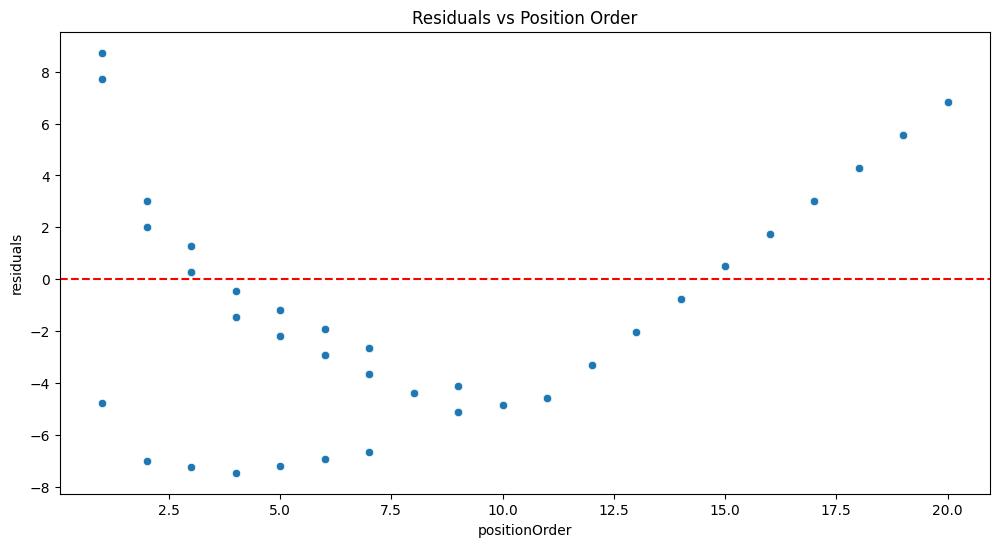

In [53]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='positionOrder', y='residuals', data=final_df)
plt.title('Residuals vs Position Order')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

 - Model regresji liniowej nie radzi sobie dobrze z przewidywaniem punktów dla skrajnych pozycji startowych, co widać po wyraźnym wzorcu w resztach.
 - Istnieje wyraźna tendencja do niedoszacowywania wyników dla dalszych pozycji startowych oraz nadoszacowywania dla czołowych pozycji startowych.


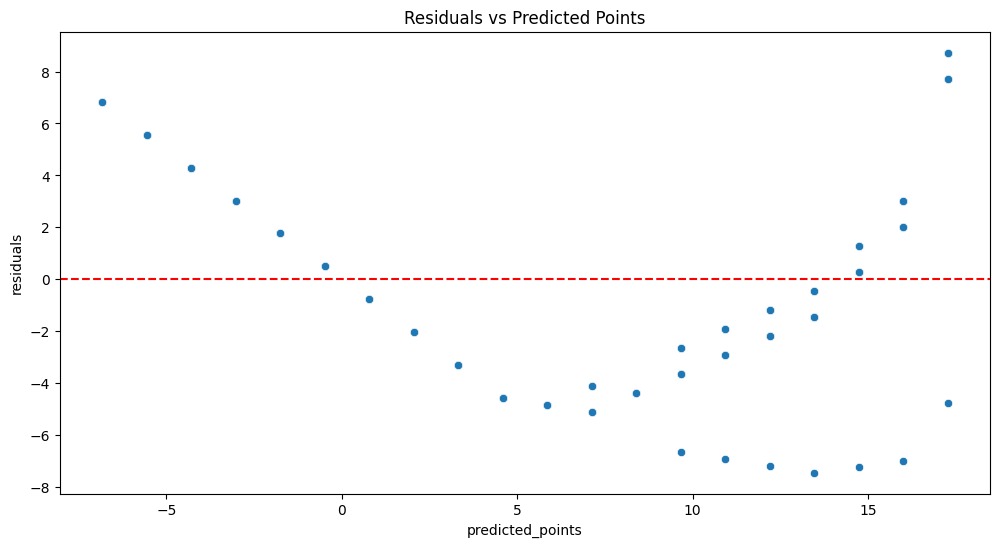

In [54]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='predicted_points', y='residuals', data=final_df)
plt.title('Residuals vs Predicted Points')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

 - Model regresji liniowej nie radzi sobie dobrze z przewidywaniem punktów zarówno dla niskich, jak i wysokich wartości przewidywanych punktów.
 - Wyraźny wzorzec w resztach sugeruje, że istnieje nieliniowa zależność, której model liniowy nie uchwycił.


Dany model progresji liniowej nie do końca radzi sobie z przewidywaniem zdobywanych punktów. Aby poprawić dokładność modelu, można rozważyć bardziej złożone modele regresji lub inne techniki modelowania, które lepiej uchwycą złożoność danych.